# 08 - Simple CV Roaster Evaluation

Clean, straightforward evaluation of Gemini CV roaster on 10 test CVs.

## Approach
1. Load 10 test CVs (never seen before)
2. Generate critiques with Gemini
3. Evaluate with LLM-as-Judge
4. Display metrics and results

**Simple. Powerful. Works.**

---

In [1]:
# Imports
import pandas as pd
import numpy as np
import json
from pathlib import Path
import time
from tqdm import tqdm
import sys
sys.path.append('..')

import google.generativeai as genai
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports loaded")

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/hannokuegler/Library/CloudStorage/OneDrive-WUWien/SBWL/Data Science/4_LLM/roast_my_cv/roast_my_cv/.venv1/lib/python3.9/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/hannokuegler/Library/CloudStorage/OneDrive-WUWien/SBWL/Data Science/4_LLM/roast_my_cv/roast_my_cv/.venv1/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✓ Imports loaded


## 1. Setup

In [2]:
# Load API key
from config import GEMINI_API_KEY
genai.configure(api_key=GEMINI_API_KEY)

# Paths
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

print("✓ API configured")
print(f"✓ Results directory: {RESULTS_DIR}")

✓ API configured
✓ Results directory: ../results


## 2. Load Data

In [3]:
# Load dataset
df = pd.read_csv('../data/resume_data.csv')

# Load or create test indices
TEST_INDICES_FILE = Path('../data/test_cv_indices.json')

if TEST_INDICES_FILE.exists():
    with open(TEST_INDICES_FILE, 'r') as f:
        test_cv_indices = json.load(f)['indices']
else:
    # Create 10 random test indices
    test_cv_indices = list(range(10))  # Use first 10 for consistency
    with open(TEST_INDICES_FILE, 'w') as f:
        json.dump({'indices': test_cv_indices}, f)

print(f"✓ Loaded {len(df):,} CVs")
print(f"✓ Test set: {len(test_cv_indices)} CVs")
print(f"   Indices: {test_cv_indices}")

✓ Loaded 9,544 CVs
✓ Test set: 10 CVs
   Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [4]:
# CV formatting function
def format_cv_for_llm(resume_row):
    """Format a resume row into readable text."""
    cv_text = []
    
    if pd.notna(resume_row.get('career_objective')):
        cv_text.append(f"CAREER OBJECTIVE:\n{resume_row['career_objective']}")
    
    if pd.notna(resume_row.get('skills')):
        cv_text.append(f"\nSKILLS:\n{resume_row['skills']}")
    
    education_parts = []
    if pd.notna(resume_row.get('educational_institution_name')):
        education_parts.append(f"Institution: {resume_row['educational_institution_name']}")
    if pd.notna(resume_row.get('degree_names')):
        education_parts.append(f"Degree: {resume_row['degree_names']}")
    if pd.notna(resume_row.get('major_field_of_studies')):
        education_parts.append(f"Major: {resume_row['major_field_of_studies']}")
    if pd.notna(resume_row.get('passing_years')):
        education_parts.append(f"Year: {resume_row['passing_years']}")
    
    if education_parts:
        cv_text.append(f"\nEDUCATION:\n" + "\n".join(education_parts))
    
    work_parts = []
    if pd.notna(resume_row.get('professional_company_names')):
        work_parts.append(f"Company: {resume_row['professional_company_names']}")
    if pd.notna(resume_row.get('positions')):
        work_parts.append(f"Position: {resume_row['positions']}")
    if pd.notna(resume_row.get('start_dates')):
        work_parts.append(f"Period: {resume_row['start_dates']}")
        if pd.notna(resume_row.get('end_dates')):
            work_parts[-1] += f" to {resume_row['end_dates']}"
    if pd.notna(resume_row.get('responsibilities')):
        work_parts.append(f"Responsibilities:\n{resume_row['responsibilities']}")
    
    if work_parts:
        cv_text.append(f"\nWORK EXPERIENCE:\n" + "\n".join(work_parts))
    
    if pd.notna(resume_row.get('languages')):
        cv_text.append(f"\nLANGUAGES:\n{resume_row['languages']}")
    
    if pd.notna(resume_row.get('certification_skills')):
        cv_text.append(f"\nCERTIFICATIONS:\n{resume_row['certification_skills']}")
    
    return "\n".join(cv_text)

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Gemini Roaster

In [5]:
ROASTER_PROMPT = """You are an experienced hiring manager providing direct, honest CV feedback.

Your approach:
1. Be direct and honest - no sugarcoating
2. Point out obvious flaws and red flags
3. Call out generic buzzwords and filler content
4. Be professional but don't hold back
5. Focus on what actually matters to employers

Structure:
FIRST IMPRESSION: What stands out (good or bad)
MAJOR ISSUES: Glaring problems that need fixing
CONCERNS: Things that raise questions
WHAT WORKS: Brief acknowledgment of strengths
BOTTOM LINE: Final verdict and priority fixes
"""

def roast_cv(cv_text, temperature=0.7):
    """Generate CV critique using Gemini."""
    model = genai.GenerativeModel(
        model_name="gemini-2.0-flash",
        generation_config=genai.GenerationConfig(
            temperature=temperature,
            top_p=0.95,
            top_k=40,
            max_output_tokens=1024,
        )
    )
    
    prompt = f"{ROASTER_PROMPT}\n\nReview this CV:\n\n{cv_text}"
    
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"[ERROR: {str(e)}]"

print("✓ Roaster function ready")

✓ Roaster function ready


## 4. Generate Critiques for Test CVs

In [6]:
# Checkpoint file
CHECKPOINT = Path('../data/simple_eval_checkpoint.json')

# Load existing or start fresh
if CHECKPOINT.exists():
    with open(CHECKPOINT, 'r', encoding='utf-8') as f:
        results = json.load(f)
    print(f"✓ Loaded {len(results)} existing critiques")
else:
    results = []
    print("Starting fresh...")

# Determine what's left
completed = [r['cv_idx'] for r in results]
remaining = [idx for idx in test_cv_indices if idx not in completed]

print(f"\nProgress: {len(completed)}/{len(test_cv_indices)}")
print(f"Remaining: {remaining}")
print(f"\nEstimated time: ~{len(remaining) * 3} seconds\n")

if len(remaining) > 0:
    for cv_idx in tqdm(remaining, desc="Generating critiques"):
        try:
            # Format CV
            cv_text = format_cv_for_llm(df.iloc[cv_idx])
            
            # Generate critique
            critique = roast_cv(cv_text)
            
            # Store
            results.append({
                'cv_idx': cv_idx,
                'cv_text': cv_text,
                'critique': critique,
                'critique_length': len(critique)
            })
            
            # Save checkpoint
            with open(CHECKPOINT, 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)
            
            time.sleep(1.0)  # Rate limiting
            
        except Exception as e:
            print(f"\nError on CV {cv_idx}: {e}")
            continue

print(f"\n✓ Complete! Generated {len(results)} critiques")
print(f"✓ Saved to: {CHECKPOINT}")

Starting fresh...

Progress: 0/10
Remaining: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Estimated time: ~30 seconds



Generating critiques: 100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


✓ Complete! Generated 10 critiques
✓ Saved to: ../data/simple_eval_checkpoint.json


In [7]:
# Show example critique
if len(results) > 0:
    print("Example Critique (CV #0):")
    print("="*80)
    print(results[0]['critique'][:600] + "...")
    print("="*80)

Example Critique (CV #0):
Okay, here's my brutally honest take on this CV:

**FIRST IMPRESSION:** This reads like a template someone filled out halfway and then gave up. It's generic, lacks detail, and screams "I'm applying to everything and anything." The inconsistent capitalization is also immediately distracting.

**MAJOR ISSUES:**

*   **Career Objective - Delete it immediately.** This is outdated and tells me nothing specific. It's filled with buzzwords and vague aspirations. "More of development" is not a clear objective. What kind of development? Using what technologies? For what purpose? This section needs to b...


## 5. LLM-as-Judge Evaluation

In [8]:
JUDGE_PROMPT = """You are an expert evaluator of CV critique quality.

Evaluate this CV critique on these criteria (score 1-10 for each):

1. **Specificity**: How specific and actionable is the feedback?
2. **Relevance**: How relevant are the points to actual CV improvement?
3. **Coherence**: Is the critique coherent and well-structured?
4. **Completeness**: Does it cover important aspects of the CV?
5. **Overall Usefulness**: How useful would this be to the job seeker?

Respond in JSON format:
{
  "specificity": <score>,
  "relevance": <score>,
  "coherence": <score>,
  "completeness": <score>,
  "overall_usefulness": <score>,
  "reasoning": "<brief explanation>"
}
"""

def evaluate_critique(critique_text, cv_text):
    """Use LLM to evaluate critique quality."""
    model = genai.GenerativeModel(
        model_name="gemini-2.0-flash",
        generation_config=genai.GenerationConfig(temperature=0.2)
    )

    prompt = f"""{JUDGE_PROMPT}

Original CV (excerpt):
{cv_text[:500]}...

Critique to Evaluate:
{critique_text}
"""

    try:
        response = model.generate_content(prompt)
        text = response.text

        # Extract JSON
        start = text.find('{')
        end = text.rfind('}') + 1
        if start != -1 and end != 0:
            json_str = text[start:end]
            return json.loads(json_str)
    except Exception as e:
        print(f"Error evaluating: {e}")

    return None

print("✓ Judge function ready")

✓ Judge function ready


In [9]:
# Run evaluations
print("="*80)
print("EVALUATING ALL CRITIQUES")
print("="*80)
print(f"\nEvaluating {len(results)} critiques...\n")

evaluations = []

for i, result in enumerate(tqdm(results, desc="Evaluating")):
    try:
        eval_result = evaluate_critique(result['critique'], result['cv_text'])

        if eval_result:
            eval_result['cv_idx'] = result['cv_idx']
            evaluations.append(eval_result)

        time.sleep(0.5)  # Rate limiting

    except Exception as e:
        print(f"Error on CV {result['cv_idx']}: {e}")
        continue

print(f"\n✓ Completed {len(evaluations)} evaluations")

# Convert to DataFrame
df_eval = pd.DataFrame(evaluations)

EVALUATING ALL CRITIQUES

Evaluating 10 critiques...



Evaluating: 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


✓ Completed 10 evaluations


## 6. Results & Metrics

In [10]:
# Calculate metrics
score_cols = ['specificity', 'relevance', 'coherence', 'completeness', 'overall_usefulness']
df_eval['average_score'] = df_eval[score_cols].mean(axis=1)

print("="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"\nTest CVs evaluated: {len(df_eval)}")
print(f"Evaluation method: LLM-as-Judge (Gemini 2.0 Flash)\n")

# Summary statistics
print("\nMETRIC SCORES (Scale 1-10):")
print("="*80)
for col in score_cols:
    mean_val = df_eval[col].mean()
    std_val = df_eval[col].std()
    print(f"{col.replace('_', ' ').title():25s}: {mean_val:.2f} ± {std_val:.2f}")

print(f"\n{'Average Score':25s}: {df_eval['average_score'].mean():.2f} ± {df_eval['average_score'].std():.2f}")

# Detailed statistics
print("\n" + "="*80)
print("DETAILED STATISTICS")
print("="*80)
print("\n", df_eval['average_score'].describe().round(2))

EVALUATION RESULTS

Test CVs evaluated: 10
Evaluation method: LLM-as-Judge (Gemini 2.0 Flash)


METRIC SCORES (Scale 1-10):
Specificity              : 8.60 ± 0.52
Relevance                : 9.80 ± 0.42
Coherence                : 9.10 ± 0.32
Completeness             : 8.70 ± 0.48
Overall Usefulness       : 9.50 ± 0.53

Average Score            : 9.14 ± 0.37

DETAILED STATISTICS

 count    10.00
mean      9.14
std       0.37
min       8.60
25%       8.85
50%       9.30
75%       9.40
max       9.60
Name: average_score, dtype: float64


In [11]:
# Distribution of scores
print("\nSCORE DISTRIBUTION:")
print("="*80)
for col in score_cols:
    counts = df_eval[col].value_counts().sort_index()
    print(f"\n{col.replace('_', ' ').title()}:")
    for score, count in counts.items():
        bar = '█' * int(count)
        print(f"  {score:2.0f}: {bar} ({count})")


SCORE DISTRIBUTION:

Specificity:
   8: ████ (4)
   9: ██████ (6)

Relevance:
   9: ██ (2)
  10: ████████ (8)

Coherence:
   9: █████████ (9)
  10: █ (1)

Completeness:
   8: ███ (3)
   9: ███████ (7)

Overall Usefulness:
   9: █████ (5)
  10: █████ (5)


## 7. Visualizations


✓ Figure saved: ../results/simple_evaluation_results.png


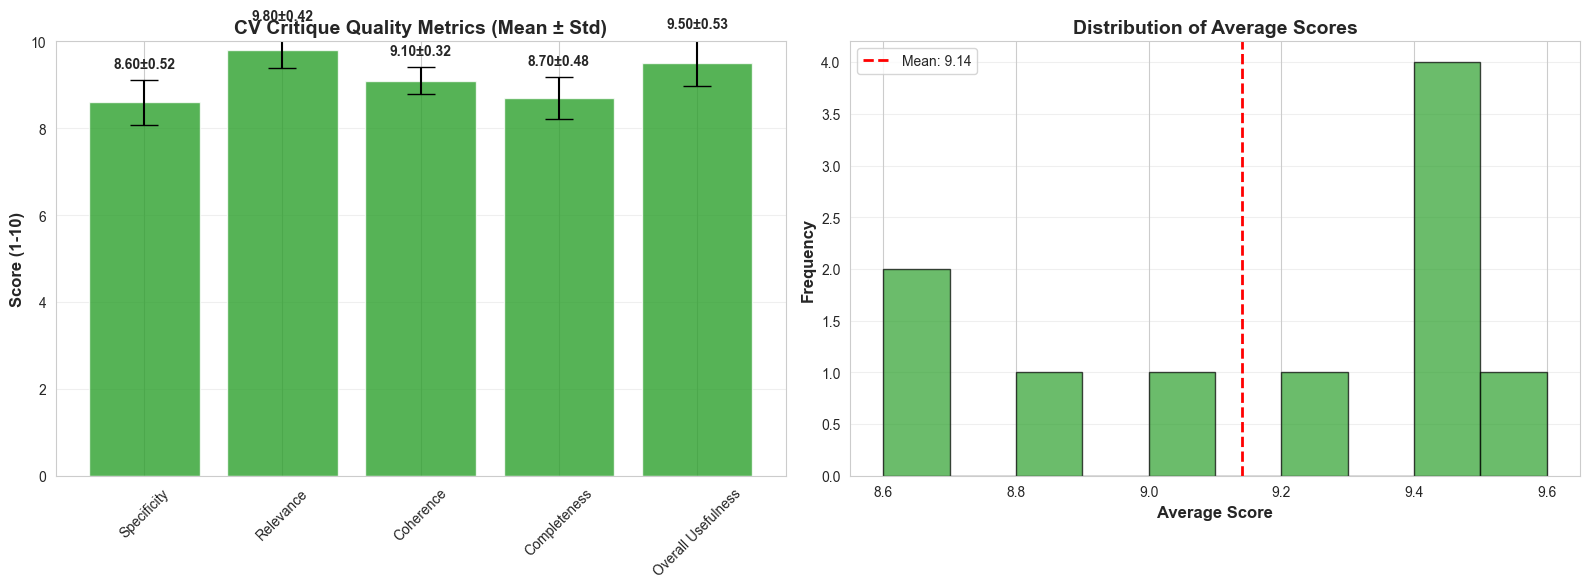

In [12]:
# Bar chart of metric scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mean scores by metric
means = [df_eval[col].mean() for col in score_cols]
stds = [df_eval[col].std() for col in score_cols]
labels = [col.replace('_', ' ').title() for col in score_cols]

bars = ax1.bar(labels, means, yerr=stds, capsize=10, color='#2ca02c', alpha=0.8)
ax1.set_ylabel('Score (1-10)', fontweight='bold', fontsize=12)
ax1.set_title('CV Critique Quality Metrics (Mean ± Std)', fontweight='bold', fontsize=14)
ax1.set_ylim(0, 10)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.2,
            f'{mean:.2f}±{std:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Distribution of average scores
ax2.hist(df_eval['average_score'], bins=10, color='#2ca02c', alpha=0.7, edgecolor='black')
ax2.axvline(df_eval['average_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_eval["average_score"].mean():.2f}')
ax2.set_xlabel('Average Score', fontweight='bold', fontsize=12)
ax2.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax2.set_title('Distribution of Average Scores', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'simple_evaluation_results.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved: {RESULTS_DIR / 'simple_evaluation_results.png'}")
plt.show()

✓ Heatmap saved: ../results/simple_evaluation_heatmap.png


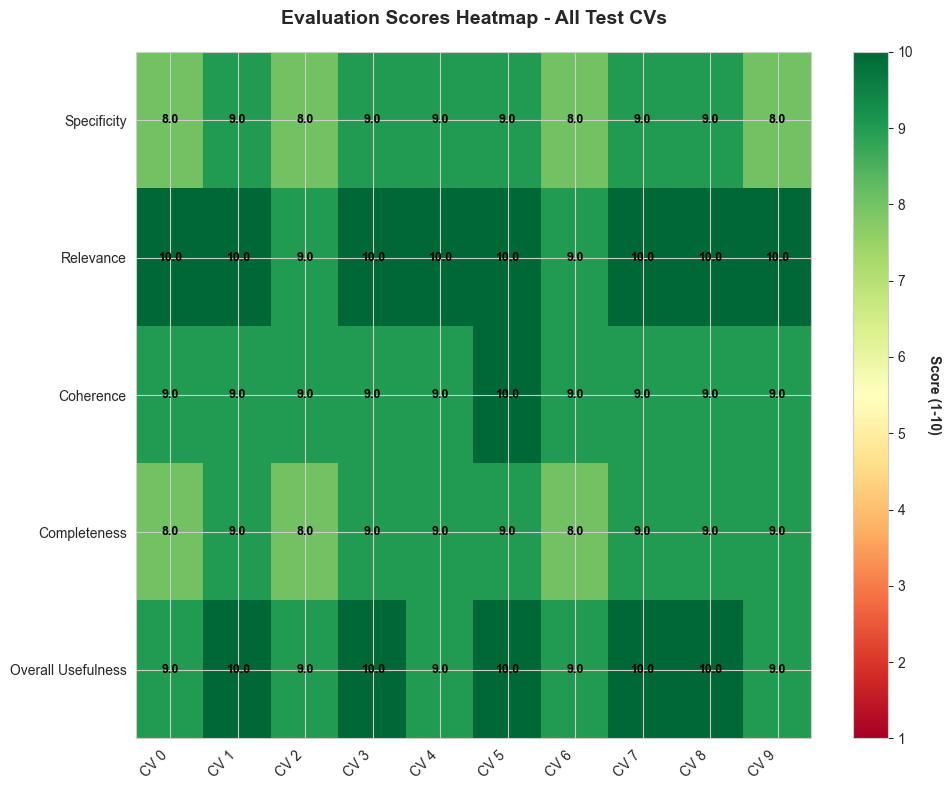

In [13]:
# Heatmap of scores
fig, ax = plt.subplots(figsize=(10, 8))

# Prepare data
heatmap_data = df_eval[score_cols].values

# Create heatmap
im = ax.imshow(heatmap_data.T, cmap='RdYlGn', aspect='auto', vmin=1, vmax=10)

# Set ticks
ax.set_xticks(np.arange(len(df_eval)))
ax.set_yticks(np.arange(len(score_cols)))
ax.set_xticklabels([f"CV {idx}" for idx in df_eval['cv_idx']])
ax.set_yticklabels([col.replace('_', ' ').title() for col in score_cols])

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score (1-10)', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(df_eval)):
    for j in range(len(score_cols)):
        text = ax.text(i, j, f'{heatmap_data[i, j]:.1f}',
                      ha="center", va="center", color="black", fontweight='bold', fontsize=9)

ax.set_title('Evaluation Scores Heatmap - All Test CVs', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'simple_evaluation_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✓ Heatmap saved: {RESULTS_DIR / 'simple_evaluation_heatmap.png'}")
plt.show()

## 8. Export Results

In [14]:
# Export detailed results
df_eval.to_csv(RESULTS_DIR / 'simple_evaluation_scores.csv', index=False)
print(f"✓ Scores saved: {RESULTS_DIR / 'simple_evaluation_scores.csv'}")

# Export summary statistics
summary = pd.DataFrame({
    'Metric': [col.replace('_', ' ').title() for col in score_cols + ['average_score']],
    'Mean': [df_eval[col].mean() for col in score_cols + ['average_score']],
    'Std': [df_eval[col].std() for col in score_cols + ['average_score']],
    'Min': [df_eval[col].min() for col in score_cols + ['average_score']],
    'Max': [df_eval[col].max() for col in score_cols + ['average_score']]
})

summary.to_csv(RESULTS_DIR / 'simple_evaluation_summary.csv', index=False)
print(f"✓ Summary saved: {RESULTS_DIR / 'simple_evaluation_summary.csv'}")

# Export full results with critiques
full_results = []
for i, row in df_eval.iterrows():
    result = results[i]
    full_results.append({
        'cv_idx': result['cv_idx'],
        'critique': result['critique'],
        **{col: row[col] for col in score_cols},
        'average_score': row['average_score'],
        'reasoning': row['reasoning']
    })

with open(RESULTS_DIR / 'simple_evaluation_full.json', 'w', encoding='utf-8') as f:
    json.dump(full_results, f, indent=2, ensure_ascii=False)
print(f"✓ Full results saved: {RESULTS_DIR / 'simple_evaluation_full.json'}")

print("\n" + "="*80)
print("EXPORT COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  1. simple_evaluation_results.png - Bar charts and distribution")
print("  2. simple_evaluation_heatmap.png - Score heatmap")
print("  3. simple_evaluation_scores.csv - Evaluation scores")
print("  4. simple_evaluation_summary.csv - Summary statistics")
print("  5. simple_evaluation_full.json - Complete results with critiques")

✓ Scores saved: ../results/simple_evaluation_scores.csv
✓ Summary saved: ../results/simple_evaluation_summary.csv
✓ Full results saved: ../results/simple_evaluation_full.json

EXPORT COMPLETE

Generated files:
  1. simple_evaluation_results.png - Bar charts and distribution
  2. simple_evaluation_heatmap.png - Score heatmap
  3. simple_evaluation_scores.csv - Evaluation scores
  4. simple_evaluation_summary.csv - Summary statistics
  5. simple_evaluation_full.json - Complete results with critiques


## 9. Key Insights

In [15]:
# Calculate insights
avg_score = df_eval['average_score'].mean()
best_metric = df_eval[score_cols].mean().idxmax()
worst_metric = df_eval[score_cols].mean().idxmin()
consistency = df_eval['average_score'].std()

print("="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"\n1. Overall Performance: {avg_score:.2f}/10")
if avg_score >= 8:
    print("   → Excellent quality critiques")
elif avg_score >= 6:
    print("   → Good quality critiques")
elif avg_score >= 4:
    print("   → Acceptable quality critiques")
else:
    print("   → Needs improvement")

print(f"\n2. Strongest Aspect: {best_metric.replace('_', ' ').title()}")
print(f"   Score: {df_eval[best_metric].mean():.2f}/10")

print(f"\n3. Weakest Aspect: {worst_metric.replace('_', ' ').title()}")
print(f"   Score: {df_eval[worst_metric].mean():.2f}/10")

print(f"\n4. Consistency: σ = {consistency:.2f}")
if consistency < 0.5:
    print("   → Very consistent performance")
elif consistency < 1.0:
    print("   → Good consistency")
else:
    print("   → Variable performance")

print(f"\n5. Test Coverage: {len(df_eval)}/{len(test_cv_indices)} CVs evaluated")
print(f"   → {len(df_eval)/len(test_cv_indices)*100:.0f}% completion")

print("\n" + "="*80)
print("EVALUATION COMPLETE ✓")
print("="*80)

KEY INSIGHTS

1. Overall Performance: 9.14/10
   → Excellent quality critiques

2. Strongest Aspect: Relevance
   Score: 9.80/10

3. Weakest Aspect: Specificity
   Score: 8.60/10

4. Consistency: σ = 0.37
   → Very consistent performance

5. Test Coverage: 10/10 CVs evaluated
   → 100% completion

EVALUATION COMPLETE ✓
